In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import keras

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import random
%matplotlib inline

In [2]:
BASE_PATH = 'crop_img/img/CLOTHING/T_Shirt/'
ids = sorted([x for x in os.listdir(BASE_PATH)])

In [3]:
ids[:5]

['id_00004844', 'id_00004845', 'id_00004866', 'id_00004879', 'id_00004893']

## make triplet
- anchor(consumer_domain)
- positive(shop_domain)
- negative(shop_domain)

In [4]:
triplets=[]
for id_ in ids:
    files = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
    con = sorted([x for x in files if 'comsumer' in x])
    shop = sorted([x for x in files if 'shop' in x ])
    combs = list(itertools.product(tuple(con),tuple(shop)))
    for comb in combs:
        comb = list(comb)
        neg_id = random.choice([x for x in ids if x != id_])
        neg_file = random.choice([BASE_PATH+neg_id+'/'+x for x in os.listdir(BASE_PATH+neg_id) if 'shop' in x])
        comb.append(neg_file)
        triplets.append(comb)
# print(triplets)

In [5]:
len(triplets)

7040

## consumer-shop画像の組み合わせ総数を計算してみる。
- 現状combに負例を追加しているのでtripletの数と同じはず

In [6]:
num = 0
for id_ in ids:
    files = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
    con = sorted([x for x in files if 'comsumer' in x])
    shop = sorted([x for x in files if 'shop' in x ])
    comb = len(list(itertools.product(tuple(con),tuple(shop))))
    num += comb
print(num)

7040


### show Triplet Samples

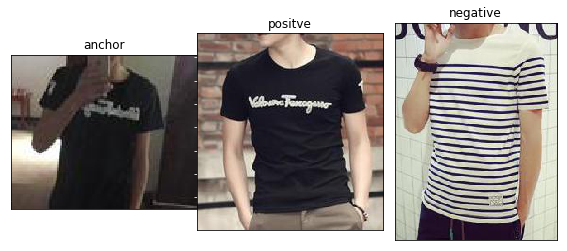

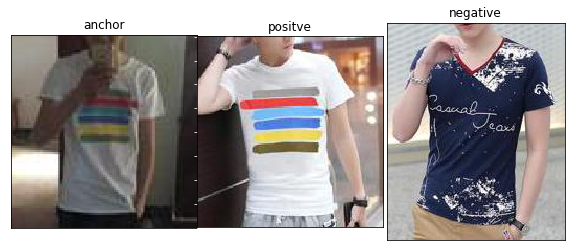

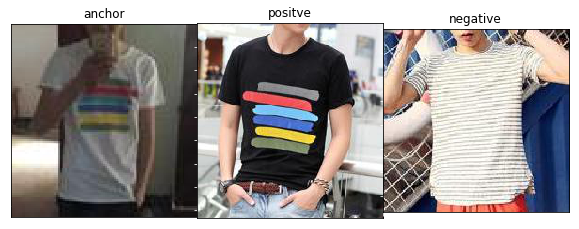

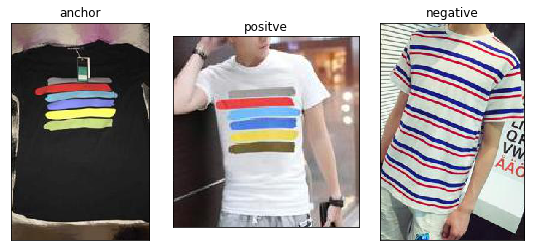

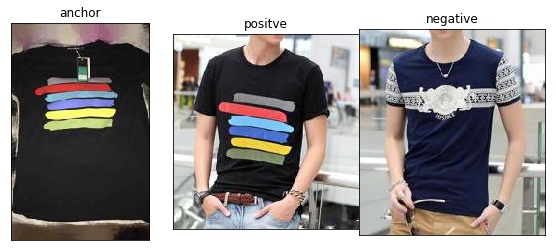

In [7]:
target = triplets[:5]
for triplet in target:
#     print(triplet)
    # load
    anc = np.array(Image.open(triplet[0]))
    pos = np.array(Image.open(triplet[1]))
    neg = np.array(Image.open(triplet[2]))
    # settings
    plt.figure(figsize=(10,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    # plot anchor
    plt.subplot(len(target),3,1)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    plt.imshow(anc)
    plt.title('anchor')
    # plot positive
    plt.subplot(len(target),3,2)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    plt.imshow(pos)
    plt.title('positve')
    # plot negative
    plt.subplot(len(target),3,3)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    plt.imshow(neg)
    plt.title('negative')
plt.savefig('./readme_imgs/tripletSample.png',bbox_inches='tight')
plt.show()

### Output as CSV file

tripletの構成画像のPATHをtxtファイルに書き出すことでのちに参照できるようにする

In [9]:
triplets[:5]

[['crop_img/img/CLOTHING/T_Shirt/id_00004844/comsumer_01.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00004844/shop_01.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00013368/shop_02.jpg'],
 ['crop_img/img/CLOTHING/T_Shirt/id_00004845/comsumer_01.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00004845/shop_01.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00009165/shop_02.jpg'],
 ['crop_img/img/CLOTHING/T_Shirt/id_00004845/comsumer_01.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00004845/shop_02.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00007566/shop_01.jpg'],
 ['crop_img/img/CLOTHING/T_Shirt/id_00004845/comsumer_02.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00004845/shop_01.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00027810/shop_01.jpg'],
 ['crop_img/img/CLOTHING/T_Shirt/id_00004845/comsumer_02.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00004845/shop_02.jpg',
  'crop_img/img/CLOTHING/T_Shirt/id_00017222/shop_01.jpg']]

In [10]:
import csv
with open('tshirt_triplets.csv','w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerows(triplets)

### Save as numpy array

In [15]:
tshirt_triplets = []
for triplet in triplets:
    anc = np.array(Image.open(triplet[0]))/255.
    pos = np.array(Image.open(triplet[1]))/255.
    neg = np.array(Image.open(triplet[2]))/255.
    tri = [anc,pos,neg]
    tshirt_triplets.append(tri)
tshirt_triplets = np.array(tshirt_triplets)
# np.save('./np_datasets/T_Shirt/NE_tshirt_triplets.npy',tshirt_triplets)

In [16]:
import numpy as np
triplets_ = []
# triplets = np.ndarray
for triplet in tshirt_triplets:
    
    anc_img = Image.fromarray(np.uint8(triplet[0])).convert('RGB')
    pos_img = Image.fromarray(np.uint8(triplet[1])).convert('RGB')
    neg_img = Image.fromarray(np.uint8(triplet[2])).convert('RGB')
    
    anc_img = np.array(anc_img.resize((128,128))) #resize to (128,128,3)
    pos_img = np.array(pos_img.resize((128,128)))    
    neg_img = np.array(neg_img.resize((128,128)))    
    
    tri = [anc_img,pos_img,neg_img]
    triplets_.append(np.array(tri))

triplets = np.array(triplets_)

In [17]:
np.save('./np_datasets/T_Shirt/128NE_tshirt_triplets.npy', triplets)

In [18]:
del tshirt_triplets

### Treat the variance of the size 

In [7]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

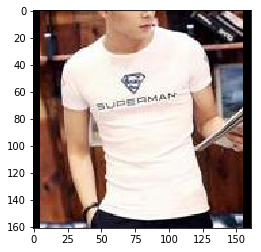

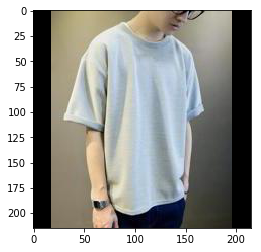

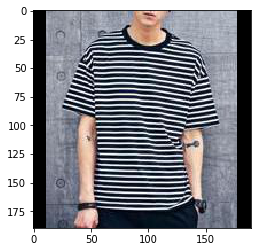

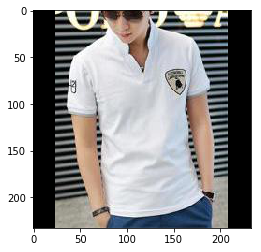

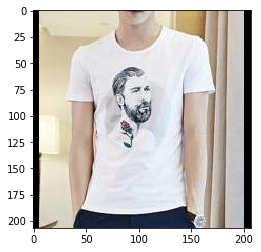

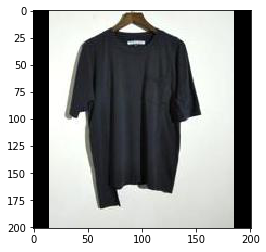

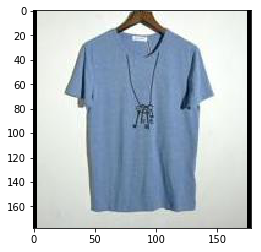

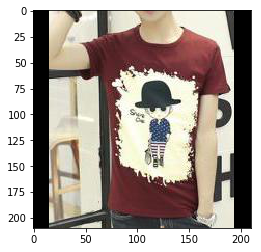

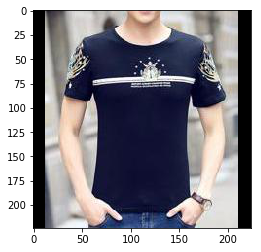

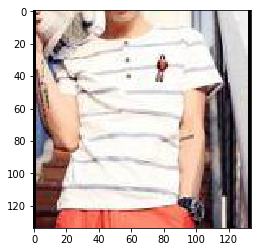

In [8]:
target = triplets[:6]
# for triplet in target:
for triplet in triplets[:10]:
    anc = Image.open(triplet[0])
    pos = Image.open(triplet[1])
    neg = Image.open(triplet[2])
    anc_new = expand2square(anc, 0)
    pos_new = expand2square(pos, 0)
    neg_new = expand2square(neg, 0)
    plt.figure()
    plt.imshow(anc_new)
    plt.imshow(pos_new)
    plt.imshow(neg_new)

plt.show()

In [10]:
tshirt_pad_triplets = []
for triplet in triplets:
    anc = Image.open(triplet[0])
    pos = Image.open(triplet[1])
    neg = Image.open(triplet[2])
    
    anc_new = expand2square(anc, 0)
    pos_new = expand2square(pos, 0)
    neg_new = expand2square(neg, 0)
    
    anc_new = np.array(anc_new)/255.
    pos_new = np.array(pos_new)/255.
    neg_new = np.array(neg_new)/255.
    
    tri = [anc_new,pos_new,neg_new]
    tshirt_pad_triplets.append(tri)
    
blouse_pad_triplets = np.array(tshirt_pad_triplets)
np.save('./np_datasets/T_Shirt/tshirt_pad_triplets.npy',tshirt_pad_triplets)

In [11]:
del tshirt_pad_triplets